<img src="pthr.jpg" style="width: 250px; float: right;" >

# Pathrise Data Intern Assignment

Our goal is to derive insights from the given data about a fellows' placement. We can idntify that the task of predicting whether a fellow is placed is a <strong>Binary Classification</strong> problem and later we shall attempt to solve the matter of <strong>*how long*</strong> using <strong>Categorical Classification</strong>.

In [1]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Exploring the data

The given excel data <code>data_Pathrise.xlsx</code> will be used to identify whether the fellow who has joined the program will eventually be placed at a company.

In [3]:
df=pd.read_excel('data_Pathrise.xlsx')

In [4]:
print(df.columns.values)

['id' 'pathrise_status' 'primary_track' 'cohort_tag'
 'program_duration_days' 'placed' 'employment_status '
 'highest_level_of_education' 'length_of_job_search'
 'biggest_challenge_in_search' 'professional_experience'
 'work_authorization_status' 'number_of_interviews'
 'number_of_applications' 'gender' 'race']


The <code>input</code> variables are <code>['id' 'pathrise_status' 'primary_track' 'cohort_tag' 'program_duration_days' 'employment_status ' 'highest_level_of_education' 'length_of_job_search' 'biggest_challenge_in_search' professional_experience' 'work_authorization_status' 'number_of_interviews' 'number_of_applications' 'gender' 'race']</code>
 
The <code>output</code> variable is <code>'placed'</code>
 
The columns with <code>unique</code> values such as <code>id</code> and <code>cohort_tag</code> in them can be dropped as they specify unique traits not necessary for learning.

In [5]:
# example of unique columns...
print(df.id.unique().any())

True


Now, we visualize the data using <code>boxplot</code> to identify outliers and confirm columns with <code>unique</code> values

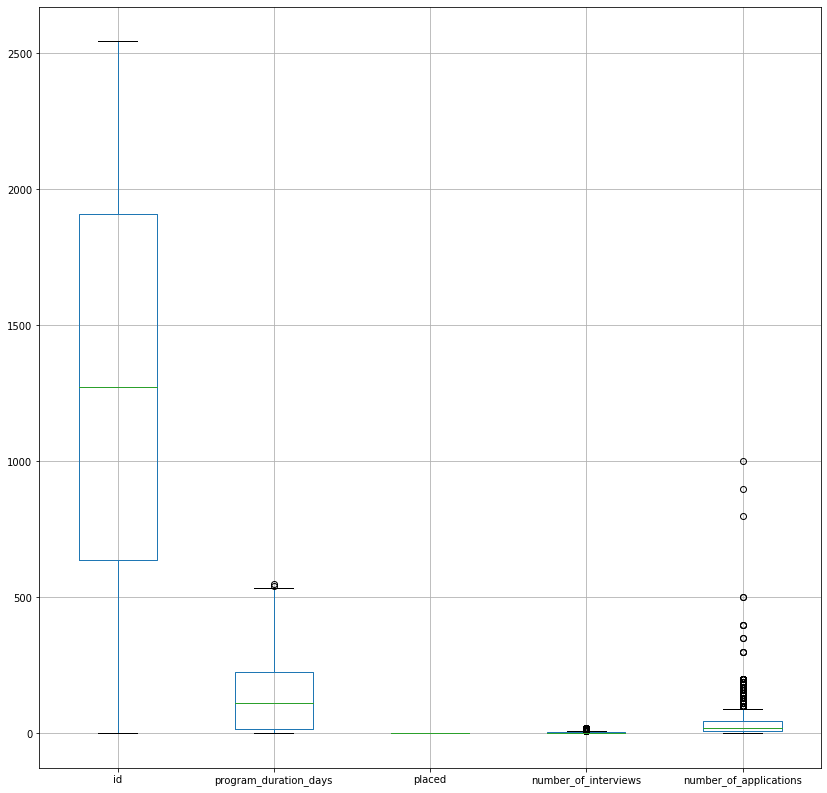

In [6]:
# boxplot to see outliers, categorical string values not shown/output
df.boxplot(figsize=(14,14))

In [7]:
# drop unique 'id' labels as they wont contribute
data = df.copy()
data.drop(columns=['id', 'cohort_tag'], inplace=True)

In [8]:
# checking for any NaN values
data.isna().any()
# we see that we do indeed have NaN values indicated by 'True' tags

pathrise_status                False
primary_track                  False
program_duration_days           True
placed                         False
employment_status               True
highest_level_of_education      True
length_of_job_search            True
biggest_challenge_in_search     True
professional_experience         True
work_authorization_status       True
number_of_interviews            True
number_of_applications         False
gender                          True
race                            True
dtype: bool

Let us now fill <code>NaN</code> values with $0$ and proceed to convert the strings into *categorical values* using <strong>*bucketizer functions*</strong>

In [9]:
print(data.shape)
data.fillna(0,inplace=True)

(2544, 14)


In [10]:
def pthr_sts_bckt(r):
    if r == 'Active':
        return 1
    elif r == 'Break':
        return 2
    elif r == 'Closed Lost':
        return 3
    elif r == 'Deferred':
        return 4
    elif r == 'MIA':
        return 5
    elif r == 'Placed':
        return 6
    elif r == 'Withdrawn':
        return 7
    elif r == 'Withdrawn (Failed)':
        return 8
    elif r == 'Withdrawn (Trial)':
        return 9
    else:
        return 0
    
data[['pathrise_status_indx']] = data[['pathrise_status']].applymap(lambda x : pthr_sts_bckt(x))

def track_bckt(r):
    if r == 'Data':
        return 1
    elif r == 'Design':
        return 2
    elif r == 'Marketing':
        return 3
    elif r == 'PSO':
        return 4
    elif r == 'SWE':
        return 5
    elif r == 'Web':
        return 6
    else:
        return 0

data[['primary_track_indx']] = data[['primary_track']].applymap(lambda x : track_bckt(x))

data[['program_duration_days_indx']] = data[['program_duration_days']].astype('int64')

data[['placed_indx']] = data[['placed']]

def emp_sts_bckt(r):
    if r == 'Contractor':
        return 1
    elif r == 'Employed Full-Time':
        return 2
    elif r == 'Employed Part-Time':
        return 3
    elif r == 'Student':
        return 4
    elif r == 'Unemployed':
        return 5
    else:
        return 0

data[['employment_status_indx']] = data[['employment_status ']].applymap(lambda x : emp_sts_bckt(x))

def edu_lvl_bckt(r):
    if r == "Bachelor's Degree":
        return 1
    elif r == "Doctorate or Professional Degree" :
        return 2
    elif r == "GED or equivalent":
        return 3
    elif r == "High School Graduate":
        return 4
    elif r == "Master's Degree" :
        return 5
    elif r == "Some College, No Degree":
        return 6
    elif r == "Some High School":
        return 7
    else:
        return 0

data[['highest_level_of_education_indx']] = data[['highest_level_of_education']].applymap(lambda x : edu_lvl_bckt(x))

def job_len_bckt(r):
    if r == '1-2 months':
        return 1
    elif r == '3-5 months':
        return 2
    elif r == '6 months to a year':
        return 3
    elif r == 'Less than one month':
        return 4
    elif r == 'Over a year':
        return 5
    else:
        return 0
    
data[['length_of_job_search_indx']] = data[['length_of_job_search']].applymap(lambda x : job_len_bckt(x))

def big_chl_bckt(r):
    if r == "Behavioral interviewing":
        return 1
    elif r == "Figuring out which jobs to apply for":
        return 2
    elif r == "Getting past final round interviews":
        return 3
    elif r == "Getting past mid-stage interviews":
        return 4
    elif r == "Getting past phone screens":
        return 5
    elif r == "Hearing back on my applications":
        return 6
    elif r == "Lack of relevant experience" :
        return 7
    elif r == "Resume gap":
        return 8
    elif r == "Technical interviewing":
        return 9
    elif r == "Technical skills":
        return 10
    else:
        return 0

data[['biggest_challenge_in_search_indx']] = data[['biggest_challenge_in_search']].applymap(lambda x : big_chl_bckt(x))

def prof_exp_bckt(r):
    if r == "1-2 years" :
        return 1
    elif r == "3-4 years":
        return 2
    elif r == "5+ years":
        return 3
    elif r == "Less than one year":
        return 4
    else:
        return 0

data[['professional_experience_indx']] = data[['professional_experience']].applymap(lambda x : prof_exp_bckt(x))

def wrk_auth_bckt(r):
    if r == 'Canada Citizen':
        return 1
    elif r == 'Citizen':
        return 2
    elif r == 'F1 Visa/CPT':
        return 3
    elif r == 'F1 Visa/OPT':
        return 4
    elif r == 'Green Card':
        return 5
    elif r == 'H1B':
        return 6
    elif r == 'Not Authorized':
        return 7
    elif r == 'Other':
        return 8
    elif r == 'STEM OPT':
        return 9
    else:
        return 0

data[['work_authorization_status_indx']] = data[['work_authorization_status']].applymap(lambda x : wrk_auth_bckt(x))

data[['number_of_interviews_indx']] = data[['number_of_interviews']].astype('int64')

data[['number_of_applications_indx']] = data[['number_of_applications']].astype('int64')

def gender_bckt(r):
    if r == 'Female':
        return 1
    elif r == 'Male':
        return 2
    elif r == 'Non-Binary':
        return 3
    elif r == 'Decline to Self Identify':
        return 4
    else:
        return 0

data[['gender_indx']] = data[['gender']].applymap(lambda x : gender_bckt(x))

def race_bckt(r):
    if r == "Black, Afro-Caribbean, or African American":
        return 1
    elif r == "East Asian or Asian American":
        return 2
    elif r == "Latino or Hispanic American":
        return 3
    elif r == "Middle Eastern or Arab American":
        return 4
    elif r == "Native American or Alaskan Native":
        return 5
    elif r == "Non-Hispanic White or Euro-American":
        return 6
    elif r == "South Asian or Indian American":
        return 7
    elif r == "Two or More Races" :
        return 8
    elif "Decline to Self Identify":
        return 9
    else:
        return 0

data[['race_indx']] = data[['race']].applymap(lambda x : race_bckt(x))


def prog_dur_bckt(r):
    if r <= 60:
        return 1
    elif r <= 120:
        return 2
    elif r <= 180:
        return 3
    elif r <= 240:
        return 4
    elif r <= 300:
        return 5
    elif r <= 360:
        return 6
    elif r <= 420:
        return 7
    elif r <= 480:
        return 8
    elif r <= 550:
        return 9
    else:
        return 0

In [11]:
print("The shape of data after bucketizing is", data.shape)
data.drop(columns=['pathrise_status', 'primary_track', 'program_duration_days', 'placed', 'employment_status ',
       'highest_level_of_education', 'length_of_job_search','biggest_challenge_in_search', 'professional_experience',
       'work_authorization_status', 'number_of_interviews','number_of_applications', 'gender', 'race'], inplace=True)
print("After dropping redundant columns, our dataframe becomes of shape",data.shape)

The shape of data after bucketizing is (2544, 28)
After dropping redundant columns, our dataframe becomes of shape (2544, 14)


In [12]:
print(data.columns.values.tolist())

print(data.info())

['pathrise_status_indx', 'primary_track_indx', 'program_duration_days_indx', 'placed_indx', 'employment_status_indx', 'highest_level_of_education_indx', 'length_of_job_search_indx', 'biggest_challenge_in_search_indx', 'professional_experience_indx', 'work_authorization_status_indx', 'number_of_interviews_indx', 'number_of_applications_indx', 'gender_indx', 'race_indx']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544 entries, 0 to 2543
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   pathrise_status_indx              2544 non-null   int64
 1   primary_track_indx                2544 non-null   int64
 2   program_duration_days_indx        2544 non-null   int64
 3   placed_indx                       2544 non-null   int64
 4   employment_status_indx            2544 non-null   int64
 5   highest_level_of_education_indx   2544 non-null   int64
 6   length_of_job_search_indx   

We can now see the new column labels as a <code>list</code> and have successfully changed all dtypes to <code>int64</code>.

Next we create a <code>schema</code> for the spark DataFrame, which will be instantiated as shown below.

In [13]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

schema = StructType([
    StructField("pathrise_status", IntegerType(), True),
    StructField("primary_track", IntegerType(), True),
    StructField("program_duration_days", IntegerType(), True),
    StructField("placed", IntegerType(), True),
    StructField("employment_status", IntegerType(), True),
    StructField("highest_level_of_education", IntegerType(), True),
    StructField("length_of_job_search", IntegerType(), True),
    StructField("biggest_challenge_in_search", IntegerType(), True),
    StructField("professional_experience", IntegerType(), True),
    StructField("work_authorization_status", IntegerType(), True),
    StructField("number_of_interviews", IntegerType(), True),
    StructField("number_of_applications", IntegerType(), True),
    StructField("gender", IntegerType(), True),
    StructField("race", IntegerType(), True),])

In [14]:
data = spark.createDataFrame(data, schema=schema)

In [15]:
data.select("placed","pathrise_status","work_authorization_status","highest_level_of_education", "program_duration_days").show(5)
# or -
#data.describe().select("placed","pathrise_status","work_authorization_status","highest_level_of_education").transpose()

+------+---------------+-------------------------+--------------------------+---------------------+
|placed|pathrise_status|work_authorization_status|highest_level_of_education|program_duration_days|
+------+---------------+-------------------------+--------------------------+---------------------+
|     0|              1|                        1|                         1|                    0|
|     0|              1|                        2|                         6|                    0|
|     0|              3|                        2|                         5|                    0|
|     0|              3|                        2|                         1|                    0|
|     1|              6|                        4|                         1|                   89|
+------+---------------+-------------------------+--------------------------+---------------------+
only showing top 5 rows



Now let us engineer new columns using <code>pipeline</code> to attain <code>features</code> and <code>label</code> columns

In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, Normalizer

indexer = StringIndexer(inputCol='placed', outputCol='label')

encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol()]).setOutputCols(["classVec"])

vectorAssembler = VectorAssembler(inputCols=['pathrise_status', 'primary_track', 'program_duration_days', 'employment_status', 
                                             'highest_level_of_education', 'length_of_job_search','biggest_challenge_in_search',
                                             'professional_experience', 'work_authorization_status', 'number_of_interviews',
                                             'number_of_applications', 'gender', 'race'], 
                                  outputCol='features')

normalizer = Normalizer(inputCol='features', outputCol='features_norm',p=1.0)

In [17]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vectorAssembler, normalizer, indexer , encoder])

### Data analysis and transformations
Take a look at the summary of the feature values in our data frame

In [18]:
numeric_features = [t[0] for t in data.dtypes if t[1] == 'int']
data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
pathrise_status,2544,5.188679245283019,2.59869548645601,1,9
primary_track,2544,4.144654088050315,1.407072648830437,1,6
program_duration_days,2544,103.14386792452831,124.11300291612753,0,548
placed,2544,0.3757861635220126,0.4844204420102632,0,1
employment_status,2544,3.252751572327044,1.5924122997392596,0,5
highest_level_of_education,2544,2.6340408805031448,2.0291129284360236,0,7
length_of_job_search,2544,2.507861635220126,1.402183955682834,0,5
biggest_challenge_in_search,2544,5.466981132075472,2.1578694302063886,0,10
professional_experience,2544,2.068396226415094,1.3293769376342117,0,4


### Correlations between independent features

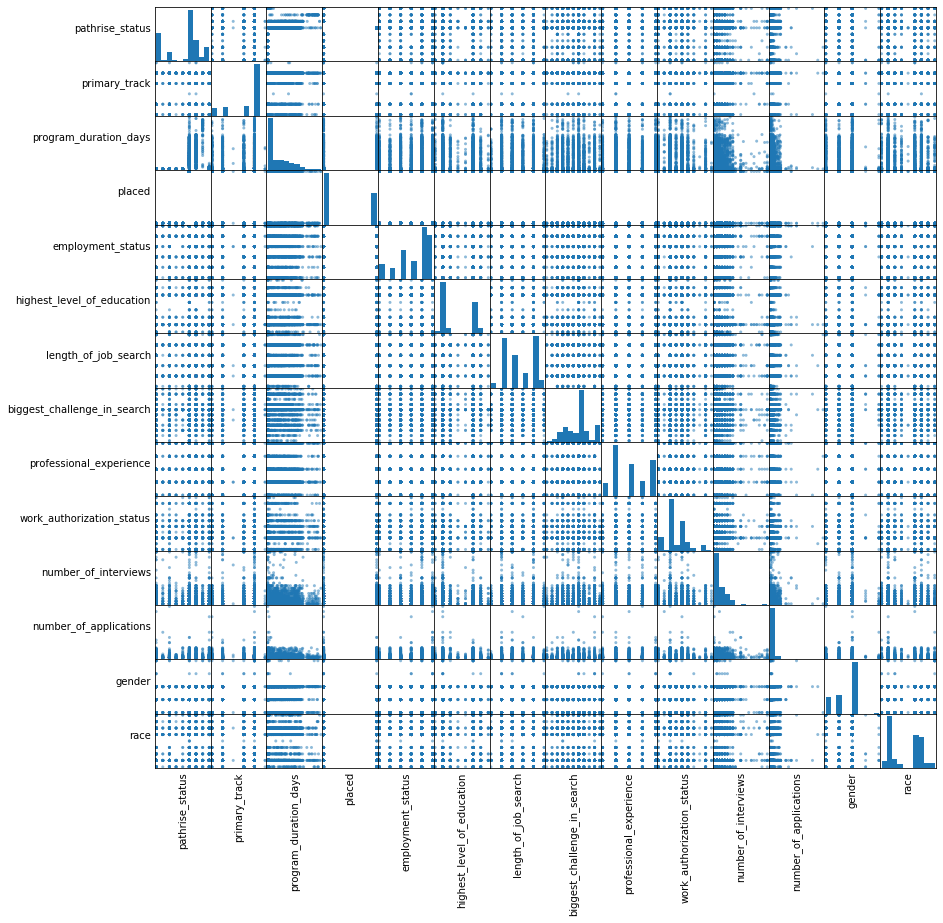

In [19]:
from pandas.plotting import scatter_matrix
numeric_data = data.select(numeric_features).toPandas()
axs = scatter_matrix(numeric_data, figsize=(14, 14));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

From the <code>scatter matrix</code> it is visible that the data is very sparsely correlated, hence dropping features would be problematic and it is best to train using the current selection of features

Next we shall once again plot the <code>boxplot</code> below to see all categorical features and their outliers

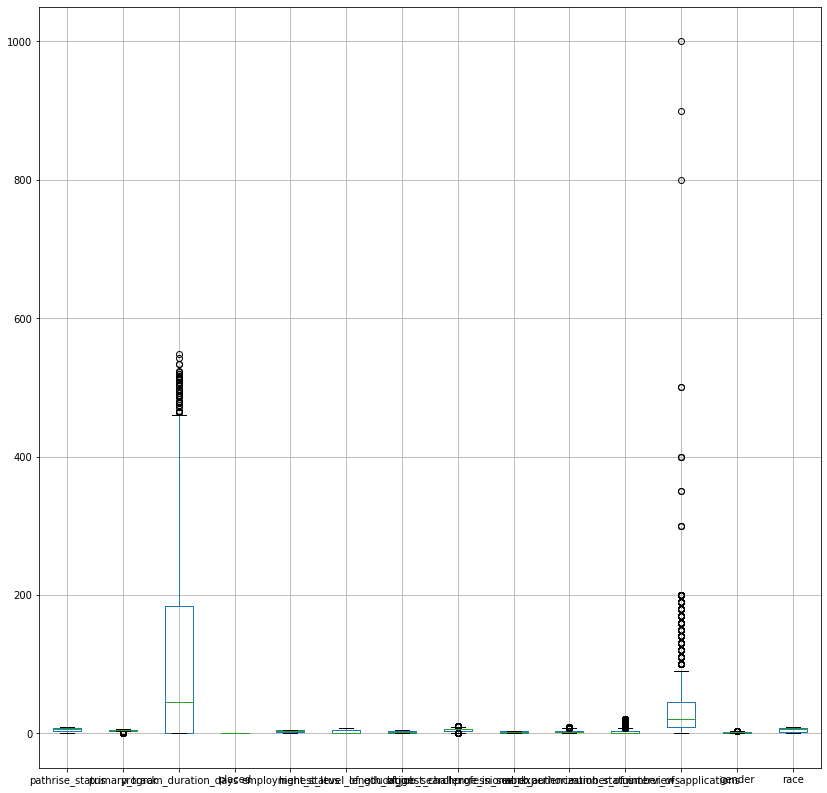

In [20]:
numeric_data.boxplot(figsize=(14,14))
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

#### Covariance matrix

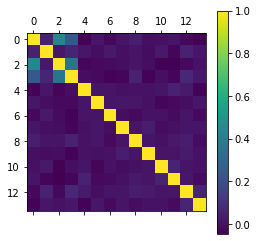

In [21]:
plt.matshow(numeric_data.corr())
plt.colorbar()
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

We notice <strong>*sparse*</strong> correlation between most features, but this implies they all contribute to the model towards learning. Some features as seen in the top-right have stronger correlation as depicted by the <code>cyan</code> colors.

#### Data preparation
Now let us generate <code>train</code> and <code>test</code> batches from the spark dataframe

In [22]:
plmodel = pipeline.fit(data)
pl_pred = plmodel.transform(data)

pl_pred.printSchema()

root
 |-- pathrise_status: integer (nullable = true)
 |-- primary_track: integer (nullable = true)
 |-- program_duration_days: integer (nullable = true)
 |-- placed: integer (nullable = true)
 |-- employment_status: integer (nullable = true)
 |-- highest_level_of_education: integer (nullable = true)
 |-- length_of_job_search: integer (nullable = true)
 |-- biggest_challenge_in_search: integer (nullable = true)
 |-- professional_experience: integer (nullable = true)
 |-- work_authorization_status: integer (nullable = true)
 |-- number_of_interviews: integer (nullable = true)
 |-- number_of_applications: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- race: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- classVec: vector (nullable = true)



We are going to split the spark data in <code>80:20</code> split

In [23]:
splits = pl_pred.randomSplit([0.8, 0.2])
data_train = splits[0]
data_test = splits[1]

### Logistic regression model
We shall specify <code>featuresCol</code>, <code>maxIter</code>, <code>regParam</code>, <code>elasticNetParam</code> and <code>LabelCol</code> for the <code>LogisticRegression</code> classifier

In [24]:
# Logistic regression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features_norm", maxIter=10, regParam=0.3, elasticNetParam=0.8).setLabelCol("placed")

In [25]:
lrModel = lr.fit(data_train)

lrPred = lrModel.transform(data_train)

lrPred.select("placed", "features", "rawPrediction", "label", "probability", "prediction").show(5)

+------+--------------------+--------------------+-----+--------------------+----------+
|placed|            features|       rawPrediction|label|         probability|prediction|
+------+--------------------+--------------------+-----+--------------------+----------+
|     0|[1.0,1.0,0.0,1.0,...|[0.65865565285941...|  0.0|[0.65895833488958...|       0.0|
|     0|[1.0,1.0,0.0,2.0,...|[0.65865565285941...|  0.0|[0.65895833488958...|       0.0|
|     0|[1.0,1.0,0.0,2.0,...|[0.65865565285941...|  0.0|[0.65895833488958...|       0.0|
|     0|[1.0,1.0,0.0,3.0,...|[0.65865565285941...|  0.0|[0.65895833488958...|       0.0|
|     0|[1.0,1.0,0.0,4.0,...|[0.65865565285941...|  0.0|[0.65895833488958...|       0.0|
+------+--------------------+--------------------+-----+--------------------+----------+
only showing top 5 rows



The 'False Postives' can be indentified by summarizing the "AreaUnderROC" for the logistic regression model

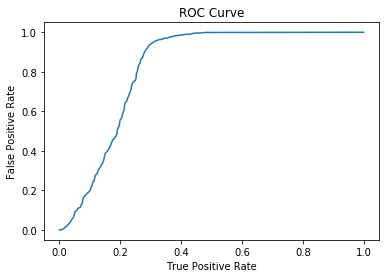

Training areaUnderROC: 0.8182599103009257


In [26]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training areaUnderROC: ' + str(trainingSummary.areaUnderROC))

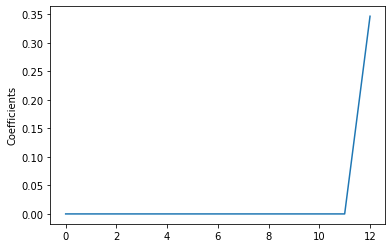

In [27]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Coefficients')
plt.show()

The coefficients for the features are as shown in the <code>plot</code> above

#### Recall and Precision

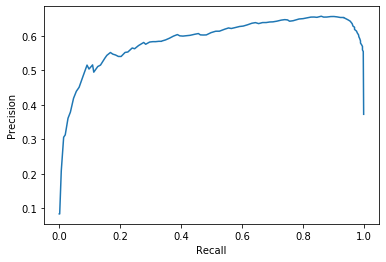

In [28]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
mulEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")
binEval = BinaryClassificationEvaluator().setMetricName("areaUnderROC").setLabelCol("label")
regEval = RegressionEvaluator().setLabelCol("label")

lgrAcc = mulEval.evaluate(lrPred)
lgrROC = binEval.evaluate(lrPred)
print("Logistic Regression Model accuracy: %.3f%%" % (lgrAcc * 100))
print("Logistic Regression Model ROC: %.3f%%" % (lgrROC * 100))

Logistic Regression Model accuracy: 62.791%
Logistic Regression Model ROC: 81.825%


### Support vector machine model
Here we specify <code>maxIter</code> and <code>regParam</code> for the <code>LinearSVC</code> classifier

In [30]:
# Support vector machine
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [31]:
svcModel = lsvc.fit(data_train)
svcPred = svcModel.transform(data_test)

svcPred.printSchema()
svcPred.select("placed", "features", "rawPrediction", "features_norm", "prediction").show(5)

root
 |-- pathrise_status: integer (nullable = true)
 |-- primary_track: integer (nullable = true)
 |-- program_duration_days: integer (nullable = true)
 |-- placed: integer (nullable = true)
 |-- employment_status: integer (nullable = true)
 |-- highest_level_of_education: integer (nullable = true)
 |-- length_of_job_search: integer (nullable = true)
 |-- biggest_challenge_in_search: integer (nullable = true)
 |-- professional_experience: integer (nullable = true)
 |-- work_authorization_status: integer (nullable = true)
 |-- number_of_interviews: integer (nullable = true)
 |-- number_of_applications: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- race: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- classVec: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = false)

+------+--------------------+-------

In [32]:
svcAcc = binEval.evaluate(svcPred)
print("Support Vector Machine model accuracy: %.3f%%" % (svcAcc * 100))

Support Vector Machine model accuracy: 79.321%


### Gradient boosted-tree model
For gradient-boosting we shall specify <code>labelCol</code>, <code>featuresCol</code> and <code>maxIter</code> for the <code>GBTClassifier</code> classifier

In [33]:
# Gradient Boosted-Tree Model
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features_norm",
                           maxIter=10)

In [34]:
gbtModel = gbt.fit(data_train)

gbtPred = gbtModel.transform(data_test)

gbtPred.select("placed", "features_norm", "rawPrediction", "label", "probability", "prediction").show(5)
gbtPred.printSchema()

+------+--------------------+--------------------+-----+--------------------+----------+
|placed|       features_norm|       rawPrediction|label|         probability|prediction|
+------+--------------------+--------------------+-----+--------------------+----------+
|     0|[0.0125,0.0125,0....|[1.32568722975004...|  0.0|[0.93409565406030...|       0.0|
|     0|[0.01219512195121...|[1.32568722975004...|  0.0|[0.93409565406030...|       0.0|
|     0|[0.03030303030303...|[1.32568722975004...|  0.0|[0.93409565406030...|       0.0|
|     0|[0.01136363636363...|[1.32568722975004...|  0.0|[0.93409565406030...|       0.0|
|     0|[0.02857142857142...|[1.32568722975004...|  0.0|[0.93409565406030...|       0.0|
+------+--------------------+--------------------+-----+--------------------+----------+
only showing top 5 rows

root
 |-- pathrise_status: integer (nullable = true)
 |-- primary_track: integer (nullable = true)
 |-- program_duration_days: integer (nullable = true)
 |-- placed: integer 

In [35]:
gbtAcc = mulEval.evaluate(gbtPred)
gbtROC = binEval.evaluate(gbtPred)
print("Gradient Boosted-Tree Model accuracy: %.3f%%" % (gbtAcc * 100))
print("Gradient Boosted-Tree Model ROC: %.3f%%" % (gbtROC * 100))

Gradient Boosted-Tree Model accuracy: 86.458%
Gradient Boosted-Tree Model ROC: 91.995%


<code>CrossValidator</code> validates the model with the evaluator against different parameters builds a new model after *tuning* the parameters. This model will be more accurate than the previous model.

In [36]:
# Cross-validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(normalizer.p, [1.0, 2.0, 10.0]) \
    .addGrid(gbt.maxBins, [2,4,8]) \
    .addGrid(gbt.maxDepth, [2,4,8]) \
    .build()

cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator().setPredictionCol("prediction").setLabelCol("label"),
                          numFolds=4)

 Please allow the model 8-10 minutes to run <code>CrossValidation</code> as it is training a lot of trees.

In [37]:
# for MulticlassClassification
cvModel = cv.fit(data_train)
cvPred = cvModel.transform(data_test)
cvAcc = mulEval.evaluate(cvPred)
cvROC = binEval.evaluate(cvPred)

print("Gradient Boosted-Tree Model accuracy: %.3f%%" % (cvAcc * 100))
print("Gradient Boosted-Tree Model ROC: %.3f%%" % (cvROC * 100))

cvPred.printSchema()
cvPred.select("placed", "features", "rawPrediction", "probability", "prediction").show(5)

Gradient Boosted-Tree Model accuracy: 83.333%
Gradient Boosted-Tree Model ROC: 90.263%
root
 |-- pathrise_status: integer (nullable = true)
 |-- primary_track: integer (nullable = true)
 |-- program_duration_days: integer (nullable = true)
 |-- placed: integer (nullable = true)
 |-- employment_status: integer (nullable = true)
 |-- highest_level_of_education: integer (nullable = true)
 |-- length_of_job_search: integer (nullable = true)
 |-- biggest_challenge_in_search: integer (nullable = true)
 |-- professional_experience: integer (nullable = true)
 |-- work_authorization_status: integer (nullable = true)
 |-- number_of_interviews: integer (nullable = true)
 |-- number_of_applications: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- race: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- classVec: vector (nullable = true)
 |-- rawPrediction: vector (nullable =

### Random forest model

In [38]:
# Random Forest Classifier
featureDf = vectorAssembler.transform(data)
featureDf.printSchema()

root
 |-- pathrise_status: integer (nullable = true)
 |-- primary_track: integer (nullable = true)
 |-- program_duration_days: integer (nullable = true)
 |-- placed: integer (nullable = true)
 |-- employment_status: integer (nullable = true)
 |-- highest_level_of_education: integer (nullable = true)
 |-- length_of_job_search: integer (nullable = true)
 |-- biggest_challenge_in_search: integer (nullable = true)
 |-- professional_experience: integer (nullable = true)
 |-- work_authorization_status: integer (nullable = true)
 |-- number_of_interviews: integer (nullable = true)
 |-- number_of_applications: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- race: integer (nullable = true)
 |-- features: vector (nullable = true)



In [39]:
labelDf = indexer.fit(featureDf).transform(featureDf)
labelDf.printSchema()

root
 |-- pathrise_status: integer (nullable = true)
 |-- primary_track: integer (nullable = true)
 |-- program_duration_days: integer (nullable = true)
 |-- placed: integer (nullable = true)
 |-- employment_status: integer (nullable = true)
 |-- highest_level_of_education: integer (nullable = true)
 |-- length_of_job_search: integer (nullable = true)
 |-- biggest_challenge_in_search: integer (nullable = true)
 |-- professional_experience: integer (nullable = true)
 |-- work_authorization_status: integer (nullable = true)
 |-- number_of_interviews: integer (nullable = true)
 |-- number_of_applications: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- race: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [40]:
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

data_trans = labelDf.rdd.map(lambda row: LabeledPoint(row[15], Vectors.dense(row[14])))

In [41]:
train_data, test_data = data_trans.randomSplit([0.8, 0.2])

rfModel = RandomForest.trainClassifier(train_data, numClasses=2, categoricalFeaturesInfo={}, 
                                       impurity='gini', numTrees=3, featureSubsetStrategy="auto")

Lets see what logic <code>RandomForest</code> came up with below -

In [42]:
print(rfModel.toDebugString())

TreeEnsembleModel classifier with 3 trees

  Tree 0:
    If (feature 2 <= 28.5)
     If (feature 7 <= 3.5)
      If (feature 2 <= 15.5)
       Predict: 0.0
      Else (feature 2 > 15.5)
       If (feature 7 <= 0.5)
        Predict: 1.0
       Else (feature 7 > 0.5)
        Predict: 0.0
     Else (feature 7 > 3.5)
      Predict: 0.0
    Else (feature 2 > 28.5)
     If (feature 2 <= 364.5)
      If (feature 0 <= 6.5)
       Predict: 1.0
      Else (feature 0 > 6.5)
       Predict: 0.0
     Else (feature 2 > 364.5)
      If (feature 0 <= 6.5)
       Predict: 1.0
      Else (feature 0 > 6.5)
       Predict: 0.0
  Tree 1:
    If (feature 0 <= 5.5)
     Predict: 0.0
    Else (feature 0 > 5.5)
     If (feature 1 <= 4.5)
      If (feature 0 <= 6.5)
       Predict: 1.0
      Else (feature 0 > 6.5)
       Predict: 0.0
     Else (feature 1 > 4.5)
      If (feature 2 <= 28.5)
       If (feature 0 <= 6.5)
        Predict: 1.0
       Else (feature 0 > 6.5)
        Predict: 0.0
      Else (feature 2 

In [43]:
rfPred = rfModel.predict(test_data.map(lambda x: x.features))
labels_and_predictions = test_data.map(lambda x: x.label).zip(rfPred)

rfAcc = labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(test_data.count())

print("Random Forest Classifier model accuracy: %.3f%%" % (rfAcc * 100))

Random Forest Classifier model accuracy: 96.091%


Out of all the models, <code>Random Forest</code> achieved the best results with an accuracy rate of {{rfAcc\*100}}.

In [54]:
%precision 3

'%.3f'

| | Logistic Regression | Support Vector Machine | Gradient Boosted-Tree | Random Forest |
|-- | ------------------- | ---------------------- | --------------------- | ------------- |
| Accuracy |  {{lgrAcc\*100}} | {{svcAcc\*100}} | {{gbtAcc\*100}} | {{rfAcc\*100}} |
| ROC | {{lgrROC\*100}} | \- | {{gbtROC\*100}} | \- |

### Saving model
We shall save the best model onto disk, so that it can be used again for another task. Once we run it on a new data set, all we need to do further is find the days and *categorize* them to our liking.

In [45]:
data.select('program_duration_days').describe().show()

+-------+---------------------+
|summary|program_duration_days|
+-------+---------------------+
|  count|                 2544|
|   mean|   103.14386792452831|
| stddev|   124.11300291612753|
|    min|                    0|
|    max|                  548|
+-------+---------------------+



In [46]:
data2 = data.rdd.filter(lambda x: x[3] == 1).collect()

In [47]:
data2 = spark.createDataFrame(data2, schema=schema)

Let us see the pairwise frequency of occurence of placed fellows and the program duration.

In [48]:
# Pairwise frequency between 'program_duration_days' & 'placed'
data.crosstab('program_duration_days', 'placed').show(5) # data2

+----------------------------+---+---+
|program_duration_days_placed|  0|  1|
+----------------------------+---+---+
|                          69|  0|  4|
|                         365|  2|  0|
|                         138|  0|  7|
|                         101|  1|  6|
|                         479|  2|  0|
+----------------------------+---+---+
only showing top 5 rows



In [49]:
time_to_place = data2.select('placed', 'program_duration_days').groupby('program_duration_days').count()
time_to_place.show(5)
#data2.crosstab('program_duration_days', 'placed') #alt code

+---------------------+-----+
|program_duration_days|count|
+---------------------+-----+
|                  148|    1|
|                  243|    3|
|                   31|    4|
|                  137|    4|
|                   85|    2|
+---------------------+-----+
only showing top 5 rows



Now we shall bucketize/group our days field into simpler terms like months using the Spark UDF below -

In [50]:
import pyspark.sql.functions as F

def prog_dur_bckt(r):
    if r <= 60:
        return 1
    elif r <= 120:
        return 2
    elif r <= 180:
        return 3
    elif r <= 240:
        return 4
    elif r <= 300:
        return 5
    elif r <= 360:
        return 6
    elif r <= 420:
        return 7
    elif r <= 480:
        return 8
    elif r <= 550:
        return 9
    else:
        return 0

ttp_bckt = F.udf(prog_dur_bckt)
    
time_to_place = time_to_place.withColumn('program_duration_days', ttp_bckt('program_duration_days'))

In [51]:
time_to_place.show()

+---------------------+-----+
|program_duration_days|count|
+---------------------+-----+
|                    3|    1|
|                    5|    3|
|                    1|    4|
|                    3|    4|
|                    2|    2|
|                    2|    6|
|                    1|    7|
|                    5|    3|
|                    8|    1|
|                    3|    2|
|                    2|    2|
|                    6|    2|
|                    7|    1|
|                    6|    2|
|                    2|    3|
|                    3|    5|
|                    4|    3|
|                    1|    6|
|                    4|    1|
|                    2|    6|
+---------------------+-----+
only showing top 20 rows



We can take a look at the counts of fellows getting placed within the defined categorical values too!

In [52]:
time_to_place.crosstab('program_duration_days', 'count').show()

+---------------------------+---+---+---+---+---+---+---+---+---+---+
|program_duration_days_count|  1| 10|  2|  3|  4|  5|  6|  7|  8|  9|
+---------------------------+---+---+---+---+---+---+---+---+---+---+
|                          8|  5|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|                          4| 11|  0| 12| 18|  7|  4|  0|  0|  0|  0|
|                          9|  5|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|                          5| 11|  0| 22| 12|  4|  2|  1|  0|  0|  0|
|                          6| 18|  0| 10| 10|  5|  0|  0|  1|  0|  0|
|                          1| 12|  1| 11| 15|  6|  2|  5|  2|  1|  0|
|                          2| 10|  1| 11|  8| 11|  6|  7|  2|  2|  1|
|                          7|  4|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|                          3| 11|  0| 10|  9| 11|  6|  5|  3|  1|  0|
+---------------------------+---+---+---+---+---+---+---+---+---+---+



In [53]:
time_to_place.groupby('program_duration_days').count().orderBy('count', ascending=False).show()

+---------------------+-----+
|program_duration_days|count|
+---------------------+-----+
|                    2|   59|
|                    3|   56|
|                    1|   55|
|                    5|   52|
|                    4|   52|
|                    6|   44|
|                    9|    5|
|                    8|    5|
|                    7|    4|
+---------------------+-----+



From this table above, we notice categorical label <code>2</code>, referring to <code>program_duration_days</code> < 120 days; has the highest number of placed fellows. This means that most fellows will be placed within 4 months of the program.